# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов
_____
<b>Цель проекта:</b>

Целью проекта является разработка модели компьютерного зрения, способной по фотографии человека определять его приблизительный возраст, для последующего использования в системе анализа покупательского поведения и контроля соблюдения правил продажи возрастных товаров в сети супермаркетов «Хлеб-Соль».
_____

<b>Задачи проекта</b>

- Изучить предоставленный датасет с изображениями людей и соответствующими значениями возраста.
- Провести исследовательский анализ данных, включая анализ размеров изображений и распределения целевой переменной.
- Подготовить данные для обучения модели, включая выбор размера входных изображений и применение методов аугментации.
- Построить и обучить модель нейронной сети для задачи регрессии возраста по изображению лица.
- Экспериментально сравнить различные подходы к обучению модели и выбрать наиболее эффективный по метрике качества.
- Оценить качество полученной модели (МАЕ не более 8) и сделать выводы о её применимости для решения поставленной задачи.
_____

<b>Описание данных</b>

Данные взяты с сайта ChaLearn Looking at People (одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`)

In [1]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from PIL import Image
from collections import Counter
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input

## Исслеловательский анализ данных

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
def show_df_info(df, name='DataFrame'):
    print(f'\n=== {name} ===')

    print('\nПервые строки:')
    display(df.head())

    print('\nИнформация о данных:')
    df.info()

    print('\nОписательная статистика:')
    display(df.describe(include="all"))

show_df_info(labels, 'faces')


=== faces ===

Первые строки:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB

Описательная статистика:


,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,005007.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


В нашем распоряжении 7591 строка без пропусков. столбец с названием файла и его реальным возрастом.
средний возраст в выборке составляет 31 год (минимальный 1 год, макимальный 100 лет). Аномальных и отрицательных значений нет.

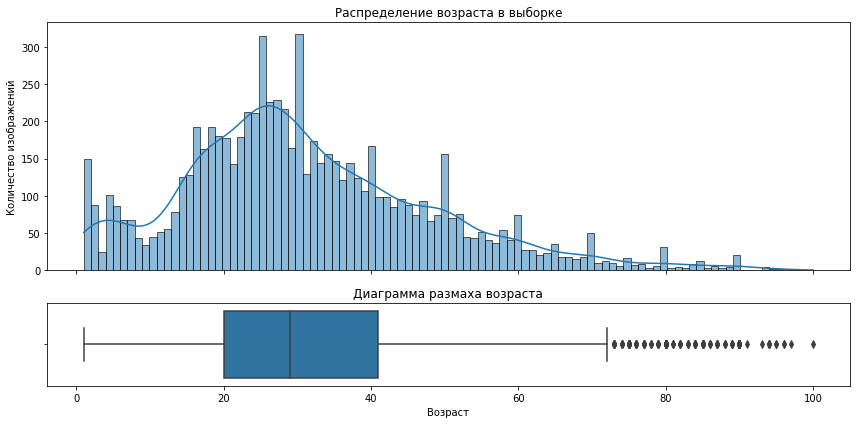

In [20]:
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 6),
    sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

sns.histplot(labels['real_age'], bins=100, kde=True, ax=ax1)
ax1.set_title('Распределение возраста в выборке')
ax1.set_ylabel('Количество изображений')
ax2.set_title('Диаграмма размаха возраста')
sns.boxplot(x=labels['real_age'], ax=ax2)
ax2.set_xlabel('Возраст')

plt.tight_layout()
plt.show()

Распределение несбалансированное.

Основная масса наблюдений — в диапазоне примерно 20–40 лет.
Очень мало изображений детей младшего возраста и пожилых людей (60+)

In [10]:
path = "/datasets/faces/final_files"
for fname in labels['file_name'].head(10):
    img = Image.open(os.path.join(path, fname))
    print(fname, img.size)

000000.jpg (114, 114)
000001.jpg (784, 784)
000002.jpg (133, 133)
000003.jpg (370, 370)
000004.jpg (212, 212)
000005.jpg (637, 636)
000006.jpg (412, 412)
000007.jpg (311, 311)
000008.jpg (897, 898)
000009.jpg (724, 724)


Исходные фотографии имеют разный размер.

In [16]:
widths = []
heights = []

for fname in labels['file_name']:
    img = Image.open(os.path.join(path, fname))
    w, h = img.size
    widths.append(w)
    heights.append(h)

sizes_df = pd.DataFrame({
    "width": widths,
    "height": heights
})

In [17]:
sizes_df["max_side"] = sizes_df[["width", "height"]].max(axis=1)
sizes_df["max_side"].describe()

count    7591.000000
mean      467.698854
std       335.313282
min        47.000000
25%       220.000000
50%       386.000000
75%       637.000000
max      4466.000000
Name: max_side, dtype: float64

Медианное значение максимальной стороны составляет 386 пикселей, а среднее — около 468 пикселей. При этом 75% изображений имеют размер не более 637 пикселей, что говорит о достаточно высоком разрешении большинства фотографий. 

Из этого можно сделать вывод, что для модели логично будет использовать размер входных изображений 320×320, так как он позволяет сохранить больше деталей лица по сравнению с меньшими размерами, не приводя к чрезмерному увеличению входных данных.

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=15,
    class_mode='raw',
    shuffle=True
)

Found 7591 validated image filenames.


In [6]:
images, ages = next(generator)

images.shape

(15, 150, 150, 3)

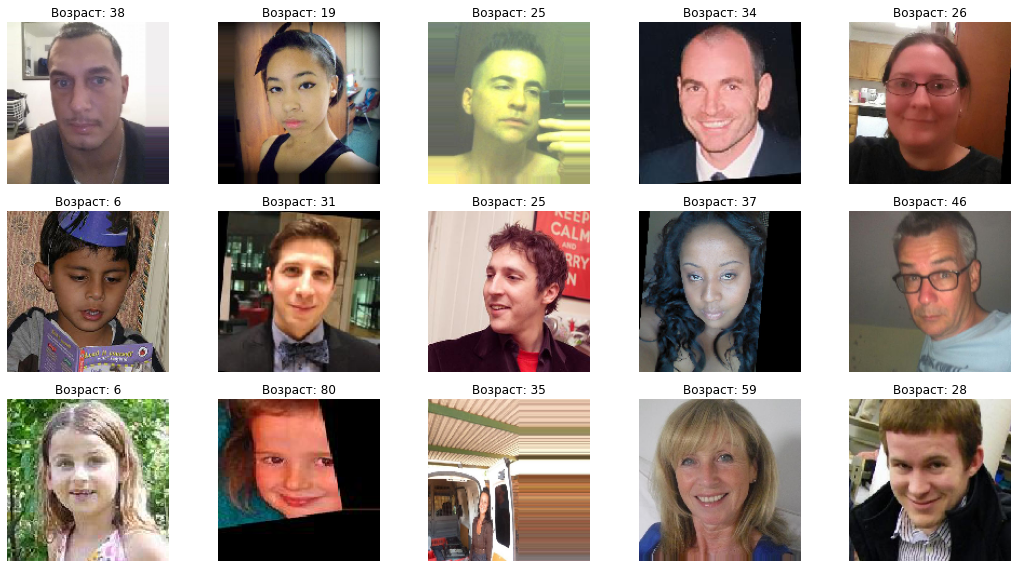

In [7]:
plt.figure(figsize=(15, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Возраст: {int(ages[i])}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Фотографии цветные, лица занимают большую часть кадра.

Из наблюдений:
- разное качество фотограций, часть фото засвечены.
- разные ракурсы (профиль, анфас)
- разные выражения лиц
- частично закрытые лица (очки, борода)

## Вывод исследовательского анализа

Проведённый исследовательский анализ показывает, что данные подходят для обучения модели ResNet50.

Несбалансированность по возрастам скорее всего занизит метрику MAE, так как модель будет лучше предсказывать возраст в диапазоне 20–40 и хуже — для детей и пожилых.
Размер исходных изображений различный, но преобладающее количество имеет высокое разрешение, что позволяет нам использовать размер 320х320 на файнтюне, в качестве входного размера изображения. В случае простой модели есть смысл оставить 224 так как предобученный ResNet50 "привык" видеть паттерны в определенном масштабе на картинках 224x224.

## Обучение модели

В рамках работы были исследованы различные подходы к обучению нейронной сети для задачи определения возраста по изображению лица. Рассматривались как простой вариант обучения без заморозки весов предобученной модели, так и более сложный подход с заморозкой backbone, аугментациями и fine-tuning.

### Простая модель

#### Простая модель:               
- размер изображения 224х224
- размер батча 16
- применяли базовую нормализацию rescale=1./255 и минимальную аугментацию (horizontal_flip)
- для регрессии возраста сверху добавили простую голову GlobalAveragePooling2D + Dense(1)
- обучена модель оптимизатором Adam с LR=1e-4 и функцией потерь MSE, метрика — MAE.

```python
def load_train(path):
    labels = pd.read_csv(f"{path}/labels.csv")

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True
    )

    train_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f"{path}/final_files",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        shuffle=True,
        seed=12345
    )
    return train_flow

def load_test(path):
    labels = pd.read_csv(f"{path}/labels.csv")

    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )

    test_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f"{path}/final_files",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224), 
        batch_size=16,
        class_mode='raw',
        subset='validation',
        shuffle=False,
        seed=12345
    )

    return test_flow


def create_model(input_shape):

    backbone = ResNet50(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )


    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['mae'] 
    )

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = train_data.n // train_data.batch_size
    if validation_steps is None:
        validation_steps = test_data.n // test_data.batch_size

    checkpoint = ModelCheckpoint(
        "best_model.h5",
        monitor=f"val_{'mae'}",
        save_best_only=True,
        mode="min",
        verbose=1,
    )

    early_stopping = EarlyStopping(
        monitor=f"val_{'mae'}",
        patience=5,
        restore_best_weights=True,
        mode="min",
        verbose=1,
    )

    class DateTimeLogger(Callback):
        def on_epoch_begin(self, epoch, logs=None):
            lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            print(
                f"\nEpoch {epoch + 1} | {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | LR={lr:.6f}"
            )
     
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        callbacks=[
            checkpoint,
            early_stopping,
            DateTimeLogger(),
        ]
    )
    model.load_weights("best_model.h5")

    return model
```

![Снимок экрана 2026-02-06 164634.png](<attachment:Снимок экрана 2026-02-06 164634.png>)
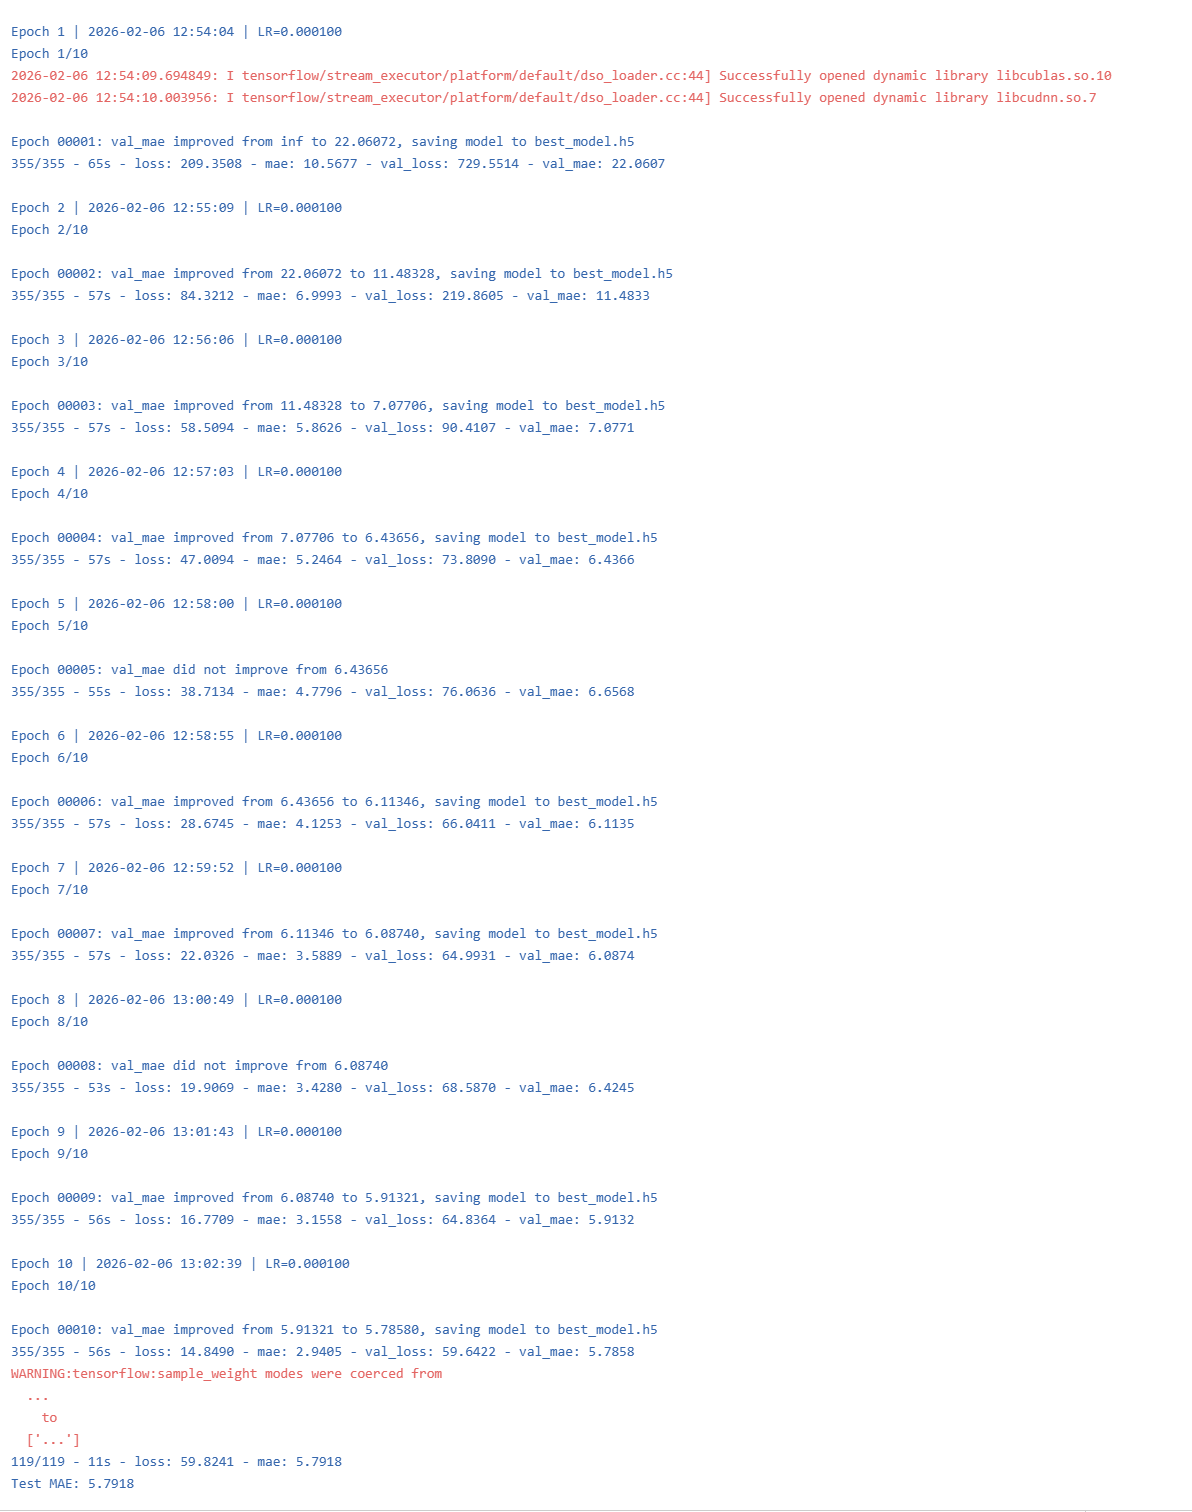

Быстрое обучение и лучшее качество по val MAE = 5.8. В ходе экспериментов было установленр, что это не случайный и воспроизводимый результат.

### Mодель c заморозкой + fine-tuning

Модель с заморозкой backbone, аугментациями и fine-tuning:
- ResNet50 без top с локальными весами, на первом этапе заморозила backbone
- обучила только регрессионную голову (два Dense слоя + Dropout) на 2 эпохи (дальше переобучается модель)
- размер изображения 256х256 и батч 8
- использовала более правильную предобработку для ResNet (preprocess_input) и расширенные аугментации (поворот, сдвиги, flip)
- функция потерь — Huber(delta=5), метрика — MAE
- на втором этапе разморозила часть сети: обучала последние 80 слоёв с очень маленьким LR=2e-6 (fine-tuning)
- 20 эпох обучения

```python
def load_train(path):
    labels = pd.read_csv(f"{path}/labels.csv")

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.25,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    train_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f"{path}/final_files",
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=8,
        class_mode='raw',
        subset='training',
        shuffle=True,
        seed=12345
    )
    return train_flow

def load_test(path):
    labels = pd.read_csv(f"{path}/labels.csv")

    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.25
    )

    test_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f"{path}/final_files",
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256), 
        batch_size=8,
        class_mode='raw',
        subset='validation',
        shuffle=False,
        seed=12345
    )

    return test_flow

def create_model(input_shape):

    backbone = ResNet50(
        input_shape=(256, 256, 3),
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )

    backbone.trainable = False  # заморозка

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss=tf.keras.losses.Huber(delta=5.0),
        metrics=['mae'] 
    )

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
     # Этап 1 — frozen backbone
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=2,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    # Этап 2 — fine-tuning 
    model.layers[0].trainable = True
    for layer in model.layers[0].layers[:-80]:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=2e-6),
        loss=tf.keras.losses.Huber(delta=5.0),
        metrics=['mae']
    )

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model
```

![Снимок экрана 2026-02-05 151720.png](<attachment:Снимок экрана 2026-02-05 151720.png>)
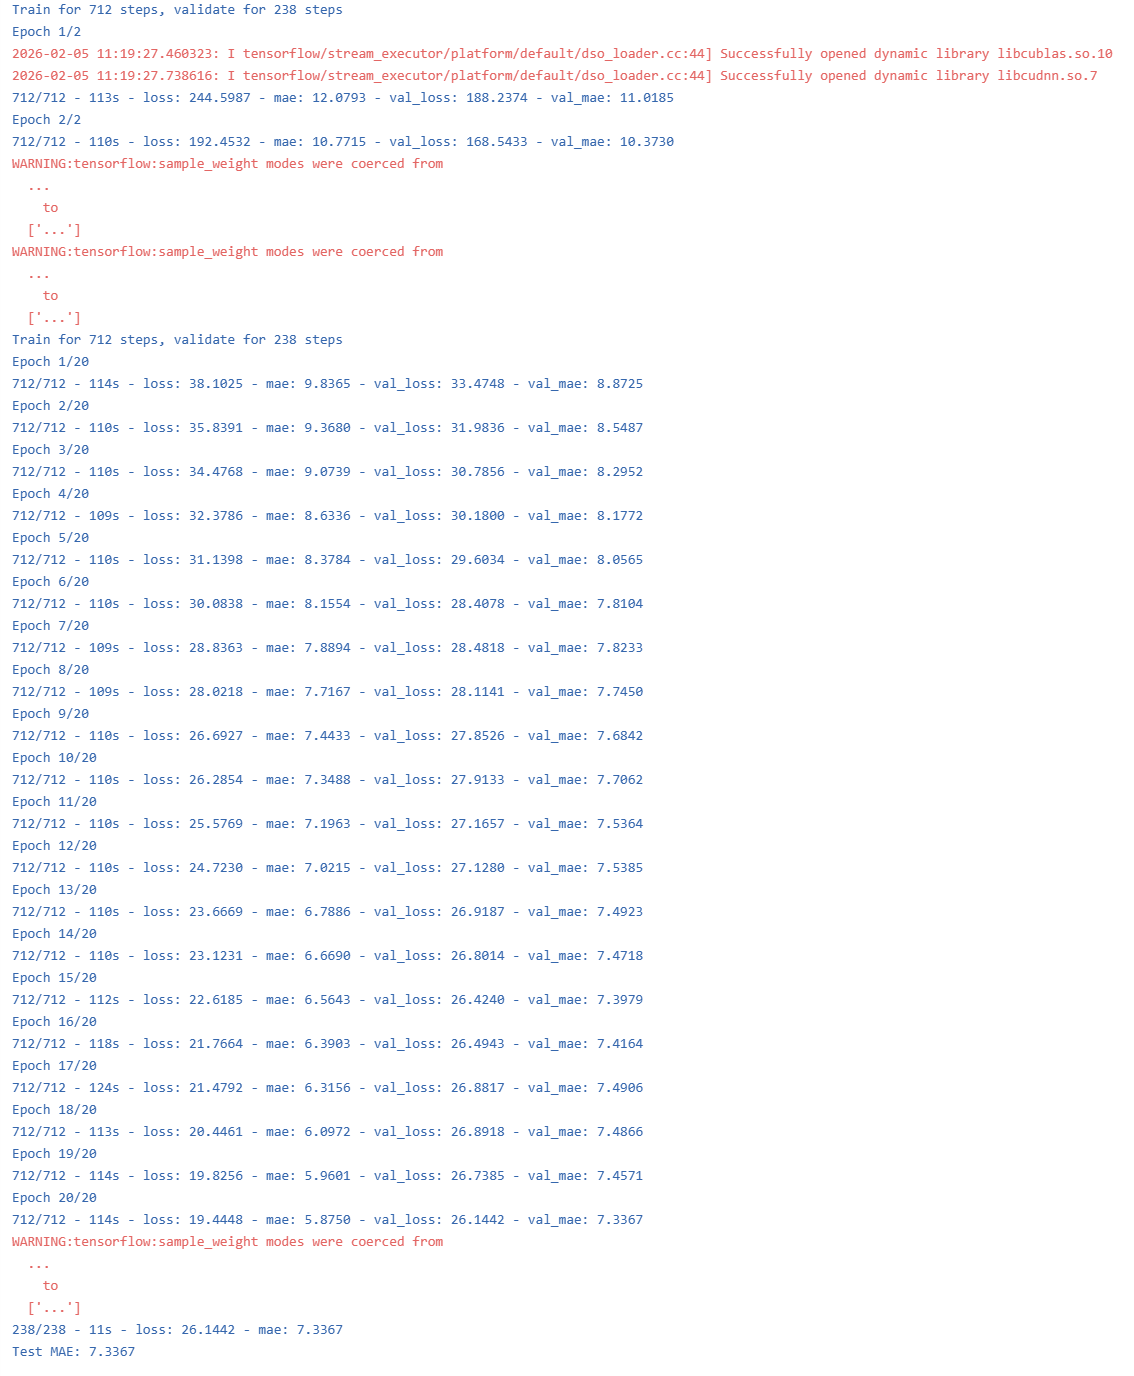

Обучение более стабильное без признаков переобучения (loss медленно падает без скачков), но итоговый val MAE = 7.3, что хуже, чем у простой схемы.

## Анализ обученной модели

В ходе работы были рассмотрены два подхода к обучению модели для определения возраста по изображению лица.           
Первый вариант представлял собой более простую модель без заморозки весов предобученной сети, второй вариант включал заморозку backbone, расширенные аугментации и этап fine-tuning. 

По результатам экспериментов более простой вариант показал лучшее качество по метрике MAE = 5.8. 

Скорее всего это связано с тем, что при обучении без заморозки модель смогла лучше адаптировать все свои параметры под конкретный датасет, а использование изображений большего размера позволило учитывать больше деталей лица, важных для определения возраста. В данном случае усложнение архитектуры и процесса обучения не привело к улучшению результата.